# 自动微分
深度学习框架通过自动计算导数，即自动微分（automatic differentiation）来加快求导。实际中，根据设计好的模型，系统会构建一个计算图（computational graph），来跟踪计算是哪些数据通过哪些操作组合起来产生输出。自动微分使系统能够随后反向传播梯度。这里，反向传播（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

对函数$y=2\mathbf{x}^{\mathbf{T}}\mathbf{x}$ 对列向量 $\mathbf{x}$ 求导

In [1]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [2]:
# 存储梯度
x.requires_grad_(True)

tensor([0., 1., 2., 3.], requires_grad=True)

In [3]:
x.grad  # 默认None

In [4]:
y = 2 * torch.dot(x, x)  # 2*torch.dot(x.T,x)也是可以的,一维张量转置不改变任何东西
y

tensor(28., grad_fn=<MulBackward0>)

In [5]:
y.backward()

In [6]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [7]:
x.grad.zero_()

tensor([0., 0., 0., 0.])

In [8]:
y = x.sum()

In [9]:
y

tensor(6., grad_fn=<SumBackward0>)

In [10]:
y.backward()

In [11]:
x.grad

tensor([1., 1., 1., 1.])

## 非标量变量的反向传播

In [12]:
x.grad.zero_()

tensor([0., 0., 0., 0.])

In [13]:
y = x * x

In [14]:
y

tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)

In [15]:
# 试一下向量对向量求导
y.backward()  #报错的

RuntimeError: grad can be implicitly created only for scalar outputs

In [16]:
y.sum().backward()

我们定义的标量损失是 $L = \sum_{i=0}^{3} y_i = \sum_{i=0}^{3} x_i^2$。
现在计算 $L$ 对每个 $x_j$ 的梯度：
$$
\frac{\partial L}{\partial x_j} = \frac{\partial}{\partial x_j} (x_0^2 + x_1^2 + x_2^2 + x_3^2) = 2x_j
$$
所以，$\mathbf{x}$ 的梯度向量应该是 $[2x_0, 2x_1, 2x_2, 2x_3] =$，这与代码输出 `tensor([0., 2., 4., 6.])` 完全一致。

In [17]:
x.grad

tensor([0., 2., 4., 6.])

## 分离计算图
有时，我们希望将某些计算移动到记录的计算图之外。例如，假设y是作为x的函数计算的，而z则是作为y和x的函数计算的。想象一下，我们想计算z关于x的梯度，但由于某种原因，希望将y视为一个常数，并且只考虑到x在y被计算后发挥的作用。

In [18]:
import torch

# 1. 创建一个需要梯度的张量 a
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(f"原始张量 a: {a}")

# 2. 对 a 进行操作得到 b
b = a * 2
print(f"张量 b: {b}")  # b 继承了 a 的梯度属性，是计算图的一部分

# 3. 使用 detach() 创建 c
c = b.detach()
print(f"分离后的张量 c: {c}")
print(f"a.requires_grad: {a.requires_grad}")  # True
print(f"b.requires_grad: {b.requires_grad}")  # True
print(f"c.requires_grad: {c.requires_grad}")  # False

# 4. 证明 c 和 b 共享数据内存
# 修改 c 的数据，b 也会改变
c[0] = 100.0
print(f"修改 c 后, b 的值: {b}")  # b 的值也变了
print(f"修改 c 后, c 的值: {c}")

# 5. 梯度计算的对比
d = b.sum()
d.backward()  # 从 d 反向传播
print(f"a 的梯度 a.grad: {a.grad}")  # tensor([2., 2., 2.])

# 如果我们尝试对 c 进行反向传播，会发生什么？
try:
    e = c.sum()
    e.backward()
except RuntimeError as e:
    # 这会报错，因为 c 不在计算图中，且 requires_grad=False
    print(f"\n对 c 求和并反向传播时出错: {e}")

原始张量 a: tensor([1., 2., 3.], requires_grad=True)
张量 b: tensor([2., 4., 6.], grad_fn=<MulBackward0>)
分离后的张量 c: tensor([2., 4., 6.])
a.requires_grad: True
b.requires_grad: True
c.requires_grad: False
修改 c 后, b 的值: tensor([100.,   4.,   6.], grad_fn=<MulBackward0>)
修改 c 后, c 的值: tensor([100.,   4.,   6.])
a 的梯度 a.grad: tensor([2., 2., 2.])

对 c 求和并反向传播时出错: element 0 of tensors does not require grad and does not have a grad_fn


In [19]:
x.grad.zero_()

tensor([0., 0., 0., 0.])

In [20]:
y = x * x

In [21]:
y

tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)

In [22]:
u = y.detach()

In [23]:
u

tensor([0., 1., 4., 9.])

In [24]:
z = u * x  # u 被看作是常数了

In [25]:
z

tensor([ 0.,  1.,  8., 27.], grad_fn=<MulBackward0>)

In [26]:
z.sum().backward()

In [27]:
x.grad

tensor([0., 1., 4., 9.])

## Python 控制流的梯度计算

In [28]:
a = torch.randn(size=(), requires_grad=True)

In [29]:
a

tensor(1.6075, requires_grad=True)

In [30]:
from torch import Tensor


def f(a: Tensor):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [31]:
d = f(a)

In [32]:
d

tensor(1646.0342, grad_fn=<MulBackward0>)

In [33]:
d.backward()

In [34]:
a.grad

tensor(1024.)

In [35]:
d/a

tensor(1024., grad_fn=<DivBackward0>)

# 课后练习
 1. 为什么计算二阶导数比一阶导数的开销要更大？

计算二阶导数的开销之所以更大，主要是因为它涉及了**两次反向传播过程**，并且需要在第一次反向传播时**构建一个额外的计算图**。

让我们从计算图的角度来理解这个过程：

1.  **计算一阶导数**:
    *   **前向传播**: 我们从输入 $x$ 开始，通过一系列运算得到输出 $y = f(x)$。PyTorch会构建一个计算图，记录下从 $x$ 到 $y$ 的所有操作。
    *   **反向传播**: 当我们调用 `y.backward()` 时，Autograd引擎会沿着这个图反向遍历，计算出 $y$ 对 $x$ 的梯度 $\frac{dy}{dx}$。计算完成后，为了节约内存，这个图默认会被**释放**。
    *   这个过程可以看作是：$x \xrightarrow{\text{构建图}} f(x) \xrightarrow{\text{反向遍历一次}} \frac{df(x)}{dx}$。

2.  **计算二阶导数**:
    *   二阶导数是**一阶导数的导数**，即 $\frac{d^2y}{dx^2} = \frac{d}{dx}(\frac{dy}{dx})$。
    *   为了计算它，我们首先需要得到一阶导数 $\frac{dy}{dx}$。但关键是，我们不能只得到它的数值，我们还需要得到**如何从 $x$ 计算出 $\frac{dy}{dx}$ 的计算图**。
    *   **第一次反向传播 (`create_graph=True`)**: 我们在第一次调用 `backward` 时，必须设置参数 `create_graph=True`。这会告诉PyTorch：在计算一阶导数的同时，请为这个求导过程本身也构建一个计算图。这个新图描述了一阶导数 $\frac{dy}{dx}$ 是如何作为 $x$ 的函数计算出来的。
    *   **第二次反向传播**: 现在我们有了一阶导数（我们称之为 `grad_x`）和它自己的计算图。我们再对 `grad_x` 进行反向传播，即调用 `grad_x.backward()`，就能得到二阶导数 $\frac{d(grad\_x)}{dx}$。
    *   这个过程可以看作是：
        $$
        x \xrightarrow{\text{(1) 正向}} f(x) \xrightarrow[\text{同时构建梯度图}]{\text{(2) 第一次反向}} \frac{df(x)}{dx} \xrightarrow{\text{(3) 第二次反向}} \frac{d^2f(x)}{dx^2}
        $$

**开销大的原因总结**:
*   **双倍的反向传播**: 执行了两次完整的反向计算过程。
*   **创建额外的图**: 第一次反向传播的计算量更大，因为它不仅要计算梯度值，还要构建一个全新的、描述梯度计算过程的计算图。这个图的创建和存储会消耗更多的计算资源和内存。


 2. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。

默认情况下，在 `.backward()` 执行完毕后，PyTorch为了提高效率、节省内存，会自动**销毁**用于计算梯度的计算图。如果尝试立即再次运行它，会触发一个 `RuntimeError`。

**会发生什么**:
程序会报错，错误信息通常是：
`RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.`

**解释**:
这个错误信息非常明确：你试图对一个图进行第二次反向传播，但是存储在图中的中间结果（比如前向传播时各节点的输出值，它们是计算梯度所必需的）已经被释放了。

**如何解决**:
如果你确实需要对同一个图进行多次反向传播（例如，在一些高级应用中，一个网络的多个输出需要分别计算梯度），你需要在**第一次**调用 `backward()` 时指定 `retain_graph=True`。

In [36]:
import torch

x = torch.tensor([2.0], requires_grad=True)
y = x ** 3
z = y * 2

# 第一次反向传播
z.backward(retain_graph=True) # retain_graph=True 保留了计算图
print(f"第一次梯度 (dz/dx): {x.grad.item()}")

# 重新清零梯度，否则梯度会累加
x.grad.zero_() 

# 立即再次运行它（因为图被保留了，所以这次会成功）
z.backward() 
print(f"第二次梯度 (dz/dx): {x.grad.item()}")

第一次梯度 (dz/dx): 24.0
第二次梯度 (dz/dx): 24.0


3. 在控制流的例子中，如果将变量a更改为随机向量或矩阵，会发生什么？

在上一节的控制流例子中，输入 `a` 和输出 `d` 都是标量（scalar）。如果将 `a` 改为向量或矩阵，会发生两件事：

1.  **控制流本身依然可以正常工作**：函数 `f(a)` 中的运算对向量和矩阵是有定义的。
    *   `b = a * 2`: 逐元素乘法，`b` 也是一个向量/矩阵。
    *   `b.norm()`: 计算 `b` 的L2范数，结果是一个**标量**。`while` 循环的条件判断依然有效。
    *   `b.sum()`: 计算 `b` 所有元素的和，结果也是一个**标量**。`if` 条件判断依然有效。
    *   因此，前向传播 `d = f(a)` 会成功执行，输出的 `d` 将是一个和 `a` 形状相同的向量或矩阵。

2.  **反向传播 `d.backward()` 会失败**：这是最关键的变化。`backward()` 方法默认只能被**标量**调用。当 `d` 是一个向量或矩阵时，直接调用 `d.backward()` 会触发 `RuntimeError`。

**会发生什么**:
程序会报错，错误信息通常是：
`RuntimeError: grad can be implicitly created only for scalar outputs`

**解释**:
梯度的概念在数学上是指一个**标量函数**关于其自变量（可以是向量或矩阵）的变化率。当函数输出是向量（例如 $d = [d_1, d_2, ..., d_n]$）时，我们无法直接定义一个“总梯度”。我们能定义的是一个**雅可比矩阵 (Jacobian Matrix)**，其中每个元素 $J_{ij} = \frac{\partial d_i}{\partial a_j}$。

PyTorch的 `.backward()` 是为深度学习中优化**标量损失函数**而设计的。它实际上计算的是梯度与一个向量的乘积，即**雅可比-向量积 (Jacobian-vector product)**。当输出是标量时，这个向量默认为1。

**如何解决**:
如果你想对一个向量输出求梯度，你有两种常见做法：
*   **方法一（最常用）**: 先将向量输出聚合为一个标量，通常是求和 `d.sum()` 或者求均值 `d.mean()`，然后再对这个标量调用 `.backward()`。这在计算总损失时非常常见。
*   **方法二**: 在调用 `backward()` 时提供一个与 `d` 形状相同的 `gradient` 张量（通常是全1的张量），如 `d.backward(gradient=torch.ones_like(d))`。这在效果上等同于 `d.sum().backward()`。

In [37]:
import torch

def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

# a 是一个向量
a = torch.randn(3, requires_grad=True)
d = f(a) # 前向传播成功

print(f"Input a: {a}")
print(f"Output d: {d}")

# d.backward() # <--- 这行会报错！

# 正确的做法:
d_sum = d.sum()
d_sum.backward()
print(f"Gradient a.grad: {a.grad}")

Input a: tensor([ 0.6271, -0.1845,  1.2266], requires_grad=True)
Output d: tensor([ 642.1505, -188.9527, 1256.0619], grad_fn=<MulBackward0>)
Gradient a.grad: tensor([1024., 1024., 1024.])


4. 重新设计一个求控制流梯度的例子，运行并分析结果。

我们可以设计一个函数，它根据输入向量的元素总和来决定应用哪种非线性变换。

**设计思路**:
*   输入是一个向量 `x`。
*   计算 `x` 的元素和 `x.sum()`。
*   如果和为正，输出为 $y = x^2$。
*   如果和为负，输出为 $y = x^3$。
这是一个依赖于数据本身的控制流。

In [38]:
import torch

def dynamic_polynomial(x):
    """
    根据输入x的元素和，动态选择一个多项式函数。
    """
    if x.sum() > 0:
        print("执行路径: y = x^2")
        y = x.pow(2)
    else:
        print("执行路径: y = x^3")
        y = x.pow(3)
    return y.sum() # 返回标量损失

# 案例1: 元素和为正
print("--- 案例 1: sum(x) > 0 ---")
x1 = torch.tensor([1.0, 2.0], requires_grad=True)
y1 = dynamic_polynomial(x1)
y1.backward()

print(f"输入 x1: {x1.data}")
print(f"输出 y1: {y1.item()}")
print(f"梯度 x1.grad: {x1.grad}") # 理论梯度: 2*x = [2.0, 4.0]

print("\n" + "="*30 + "\n")

# 案例2: 元素和为负
print("--- 案例 2: sum(x) <= 0 ---")
x2 = torch.tensor([-1.0, -2.0], requires_grad=True)
y2 = dynamic_polynomial(x2)
y2.backward()

print(f"输入 x2: {x2.data}")
print(f"输出 y2: {y2.item()}")
print(f"梯度 x2.grad: {x2.grad}") # 理论梯度: 3*x^2 = [3.0, 12.0]

--- 案例 1: sum(x) > 0 ---
执行路径: y = x^2
输入 x1: tensor([1., 2.])
输出 y1: 5.0
梯度 x1.grad: tensor([2., 4.])


--- 案例 2: sum(x) <= 0 ---
执行路径: y = x^3
输入 x2: tensor([-1., -2.])
输出 y2: -9.0
梯度 x2.grad: tensor([ 3., 12.])


5. 使 $f(x) = \sin(x)$，绘制 $f(x)$ 和 $\frac{df(x)}{dx}$ 的图像，其中后者不使用 $f'(x) = \cos(x)$。

这个练习的目标是展示如何利用Autograd来**自动计算**一个函数的导数，而无需我们手动推导其解析形式。

**实现思路**:
1.  创建一个需要计算梯度的`x`张量，它应该包含一系列点，以便我们绘图。
2.  计算 $y = \sin(x)$。
3.  因为 `y` 是一个向量，我们调用 `y.sum().backward()` 来计算每个点上的梯度。
4.  梯度值会自动存储在 `x.grad` 中。

In [45]:
from d2l import torch as d2l


In [46]:
x = torch.arange(-5,5,0.1,dtype=torch.float32,requires_grad=True)
x

tensor([-5.0000e+00, -4.9000e+00, -4.8000e+00, -4.7000e+00, -4.6000e+00,
        -4.5000e+00, -4.4000e+00, -4.3000e+00, -4.2000e+00, -4.1000e+00,
        -4.0000e+00, -3.9000e+00, -3.8000e+00, -3.7000e+00, -3.6000e+00,
        -3.5000e+00, -3.4000e+00, -3.3000e+00, -3.2000e+00, -3.1000e+00,
        -3.0000e+00, -2.9000e+00, -2.8000e+00, -2.7000e+00, -2.6000e+00,
        -2.5000e+00, -2.4000e+00, -2.3000e+00, -2.2000e+00, -2.1000e+00,
        -2.0000e+00, -1.9000e+00, -1.8000e+00, -1.7000e+00, -1.6000e+00,
        -1.5000e+00, -1.4000e+00, -1.3000e+00, -1.2000e+00, -1.1000e+00,
        -1.0000e+00, -9.0000e-01, -8.0000e-01, -7.0000e-01, -6.0000e-01,
        -5.0000e-01, -4.0000e-01, -3.0000e-01, -2.0000e-01, -1.0000e-01,
        -2.9802e-09,  1.0000e-01,  2.0000e-01,  3.0000e-01,  4.0000e-01,
         5.0000e-01,  6.0000e-01,  7.0000e-01,  8.0000e-01,  9.0000e-01,
         1.0000e+00,  1.1000e+00,  1.2000e+00,  1.3000e+00,  1.4000e+00,
         1.5000e+00,  1.6000e+00,  1.7000e+00,  1.8

In [47]:
y = torch.sin(x)

In [48]:
y.sum().backward()

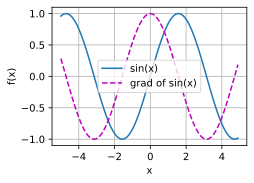

In [49]:
d2l.plot(x.detach().numpy(), 
     [y.detach().numpy(), x.grad.detach().numpy()], 
     'x', 'f(x)', 
     legend=['sin(x)', 'grad of sin(x)'])#使用 .detach().numpy() 将张量转换为matplotlib可识别的numpy数组